In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
pd.options.mode.chained_assignment = None; ## avoid warning
#from datetime import datetime;
import time;
## time.process_time() to record the time

import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/My Drive/Code Colab/Torch_Tools";
os.chdir(path);
os.listdir(path);

from YZ_torch_tools import YZ_nn_model;
from YZ_torch_tools import YZ_nn_layer;
from YZ_torch_tools import YZ_nn_optimize;

path = "/content/drive/My Drive/Code Colab/Sentiment analysis/CNN";
os.chdir(path);
os.listdir(path);

import torch;
import torch.nn as nn;
import torchtext.data as ttd;
from torchtext.vocab import GloVe;

Mounted at /content/drive


# Data acquire!


In [2]:
'''
import torch
import random
import time
import spacy
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch.nn.functional as F


SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True
 
TEXT = data.Field(tokenize='spacy')
#TEXT = data.Field();
''''''
TEXT = data.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    #tokenize = 'spacy',
    pad_first = True
)''''''
LABEL = data.LabelField(dtype=torch.float)
#LABEL = data.Field();

#LABEL = data.Field(sequential = False, use_vocab = False, is_target = True);
 

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL);
print("The length of train_data is %s\nThe length of test_data is %s"%(len(train_data), len(test_data)));

train_data, valid_data = train_data.split(random_state=random.seed(SEED))
'''

'\nimport torch\nimport random\nimport time\nimport spacy\nfrom torchtext import data\nfrom torchtext import datasets\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n\nSEED = 1\ntorch.manual_seed(SEED)\ntorch.cuda.manual_seed(SEED)\n#torch.backends.cudnn.deterministic = True\n \nTEXT = data.Field(tokenize=\'spacy\')\n#TEXT = data.Field();\n\nTEXT = data.Field(\n    sequential = True,\n    batch_first = True,\n    lower = True,\n    #tokenize = \'spacy\',\n    pad_first = True\n)\nLABEL = data.LabelField(dtype=torch.float)\n#LABEL = data.Field();\n\n#LABEL = data.Field(sequential = False, use_vocab = False, is_target = True);\n \n\ntrain_data, test_data = datasets.IMDB.splits(TEXT, LABEL);\nprint("The length of train_data is %s\nThe length of test_data is %s"%(len(train_data), len(test_data)));\n\ntrain_data, valid_data = train_data.split(random_state=random.seed(SEED))\n'

In [0]:
df = pd.read_csv('/content/drive/My Drive/Code Colab/Sentiment analysis/CNN/IMDB Dataset.csv');

df['binary_labels'] = df['sentiment'].map({'negative':0, 'positive':1});
df2 = df[['binary_labels','review']];

df2.to_csv('IMDB_NN_set.csv', index = False);

K_class = 2;



In [4]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = False,
    #tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True);
dataset = ttd.TabularDataset(path = 'IMDB_NN_set.csv', format = 'csv',
                             skip_header = True,
                             fields = [('label', LABEL),('data', TEXT)] 
                             ## it will generate an obj dattset.example.data
                             ## and an obj dattset.example.label
                             );

train_dataset, test_dataset = dataset.split(0.7);## default 0.7 here
TEXT.build_vocab(train_dataset);
vocab = TEXT.vocab;
print(len(vocab));
#vocab.stoi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device);

train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data), ## x is this object
    batch_sizes = (32,1000),
    device = device
    );
print(len(train_dataset));
print(len(test_dataset));

350667
cuda:0
35000
15000


# Console:

In [0]:
mode = "RNN";

## CNN

In [0]:
if mode == "CNN":    
    Embed_dim = 20;
    embed_layer = [["Embedding",Embed_dim]];
    conv_layer = [["Permute"],["Conv1d",32,3,2],
                ["ReLU"],["Dropout", 0.25],["MaxPool1d",2],["Conv1d",64,3,2],
                ["ReLU"],["Dropout", 0.25],["MaxPool1d",2], ["Conv1d",128,3,2],
                ["ReLU"],["Dropout", 0.25],["Permute"], ["Torch_max", 1]];
    ann_layer = [["Linear", 64],["ReLU"], ["Dropout", 0.25],["Linear", 32],
                ["ReLU"], ["Dropout", 0.25], ["Linear", K_class],["Softmax"]];
    ann_layer = [["Linear", K_class]];

    LD = YZ_nn_layer(len(vocab));
    LD.YZ_nn_sequential(embed_layer);
    LD.YZ_nn_sequential(conv_layer);
    LD.YZ_nn_sequential(ann_layer);
    #LD.Show();

    YZ_model = YZ_nn_model(LD.Seq);  
    YZ_train = YZ_nn_optimize(YZ_model, train_iter, test_iter, K_class = K_class);
    YZ_train.Optimizing(lr = 4e-4, epochs = 10, plot_epoch = 1);          

## LSTM RNN

In [0]:
class nn_LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, device):
        super(nn_LSTM,self).__init__();
        self.V = n_vocab;
        self.D = embed_dim;
        self.M = n_hidden;
        self.K = n_outputs;
        self.L = n_rnnlayers;

        self.device = device;

        self.embed = nn.Embedding(self.V, self.D);
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True,
            dropout = 0.25
        );

        self.drop = nn.Dropout(0.25);

        self.softmax = nn.Softmax(dim=1);
        self.fc = nn.Linear(self.M,self.K);

    def forward(self, X):
        ## init hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device);
        c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device);
        #h0 = torch.zeros(self.L, X.size(0), self.M);
        #c0 = torch.zeros(self.L, X.size(0), self.M);

        ## embedding layer
        ## words index 2 into word vectors
        out = self.embed(X);
        out = self.drop(out);
        ## get rnn unit output
        out,_ = self.rnn(out, (h0,c0));

        ## max pool
        out,_ = torch.max(out,1);
        ## we only need h(T) finally

        out = self.drop(out);
        #out = self.fc(out);
        #out = self.softmax(out);
        return out;

In [8]:

V = len(vocab);
D = 20;
M = 8;
L = 1;
LD = YZ_nn_layer(V);


LD.Insert_Seq([1,nn_LSTM(V,D,  M, L ,K_class, device)],V, M)

full_layer = [["Linear", 32],["ReLU"], ["Dropout", 0.25], ["Linear", 16],["ReLU"], ["Linear", K_class]];
#full_layer = [["Linear", 2]]
LD.YZ_nn_sequential(full_layer);

LD.Show();

[['YIZHOU_layer', Sequential(
  (0): Costum_module_mono_out(
    (mod): nn_LSTM(
      (embed): Embedding(350667, 20)
      (rnn): LSTM(20, 8, batch_first=True, dropout=0.25)
      (drop): Dropout(p=0.25, inplace=False)
      (softmax): Softmax(dim=1)
      (fc): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)], ['YIZHOU_layer', Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=2, bias=True)
)]]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Doing a classification with 2 label(s)!
Epoch (1 / 15)...Train_Loss: 6.933e-01...Test_loss: 6.927e-01...Duration: 3.690e+01 sec
Epoch (2 / 15)...Train_Loss: 6.713e-01...Test_loss: 6.391e-01...Duration: 7.324e+01 sec
Epoch (3 / 15)...Train_Loss: 6.188e-01...Test_loss: 6.000e-01...Duration: 1.102e+02 sec
Epoch (4 / 15)...Train_Loss: 5.732e-01...Test_loss: 5.604e-01...Duration: 1.469e+02 sec
Epoch (5 / 15)...Train_Loss: 5.230e-01...Test_loss: 5.196e-01...Duration: 1.833e+02 sec
Epoch (6 / 15)...Train_Loss: 4.608e-01...Test_loss: 4.839e-01...Duration: 2.201e+02 sec
Epoch (7 / 15)...Train_Loss: 4.062e-01...Test_loss: 4.688e-01...Duration: 2.558e+02 sec
Epoch (8 / 15)...Train_Loss: 3.612e-01...Test_loss: 4.386e-01...Duration: 2.914e+02 sec
Epoch (9 / 15)...Train_Loss: 3.258e-01...Test_loss: 4.165e-01...Duration: 3.272e+02 sec
Epoch (10 / 15)...Train_Loss: 2.938e-01...Test_loss: 4.120e-01...Duration: 3.626e+02 sec
Epoch (11 / 15)...Train_Loss: 2.634e-01...Test_loss: 4.100e-01...Duration: 3.97

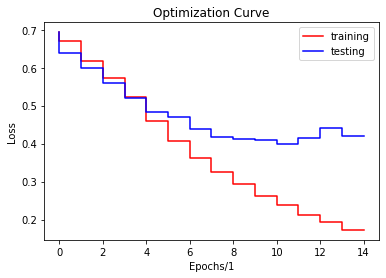

In [9]:
if mode == "RNN":
    lr = 1e-3;
    YZ_model2 = YZ_nn_model(LD.Seq);

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
    criterion = nn.BCEWithLogitsLoss(); ## Python can even return a function
    optimizer = torch.optim.Adam(YZ_model2.parameters(),lr=lr);

    YZ_train2 = YZ_nn_optimize(YZ_model2, train_iter, test_iter, device = False, K_class = K_class);
    YZ_train2.Optimizing(lr=lr, criterion = criterion, optimizer = False, epochs = 15, plot_epoch = 1);